# House Prices - Linear Regression - Israel Chaparrro

## 1. Get Data

In [139]:
# import libraries
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np

# get data
train = pd.read_csv('https://raw.githubusercontent.com/ichaparroc/house-prices/master/train.csv', index_col=0)
test = pd.read_csv('https://raw.githubusercontent.com/ichaparroc/house-prices/master/test.csv', index_col=0)

## 2. Data Exploration

In [140]:
# display the first 5 rows
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [141]:
# check the shape of the DataFrame (rows, columns)
train.shape

(1460, 80)

In [142]:
# description of target
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

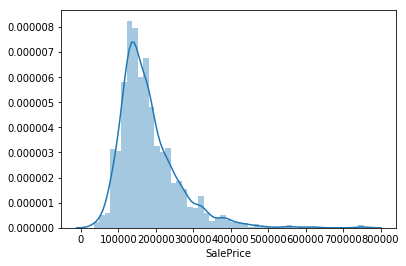

In [143]:
# plot of distribution of SalePrice
sns.distplot(train['SalePrice']);

In [144]:
# see the correlation for the variables to SalesPrice (target)
corr = train.corr()
corr_abs = corr.abs()
corr_abs['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr     0.135907
EnclosedPorch    0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass       0.084284
OverallCond      0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold           0.028923
LowQualFinSF     0.025606
MiscVal          0.021190
BsmtHalfBath     0.016844
BsmtFinSF2       0.011378
Name: SalePrice, dtype: float64

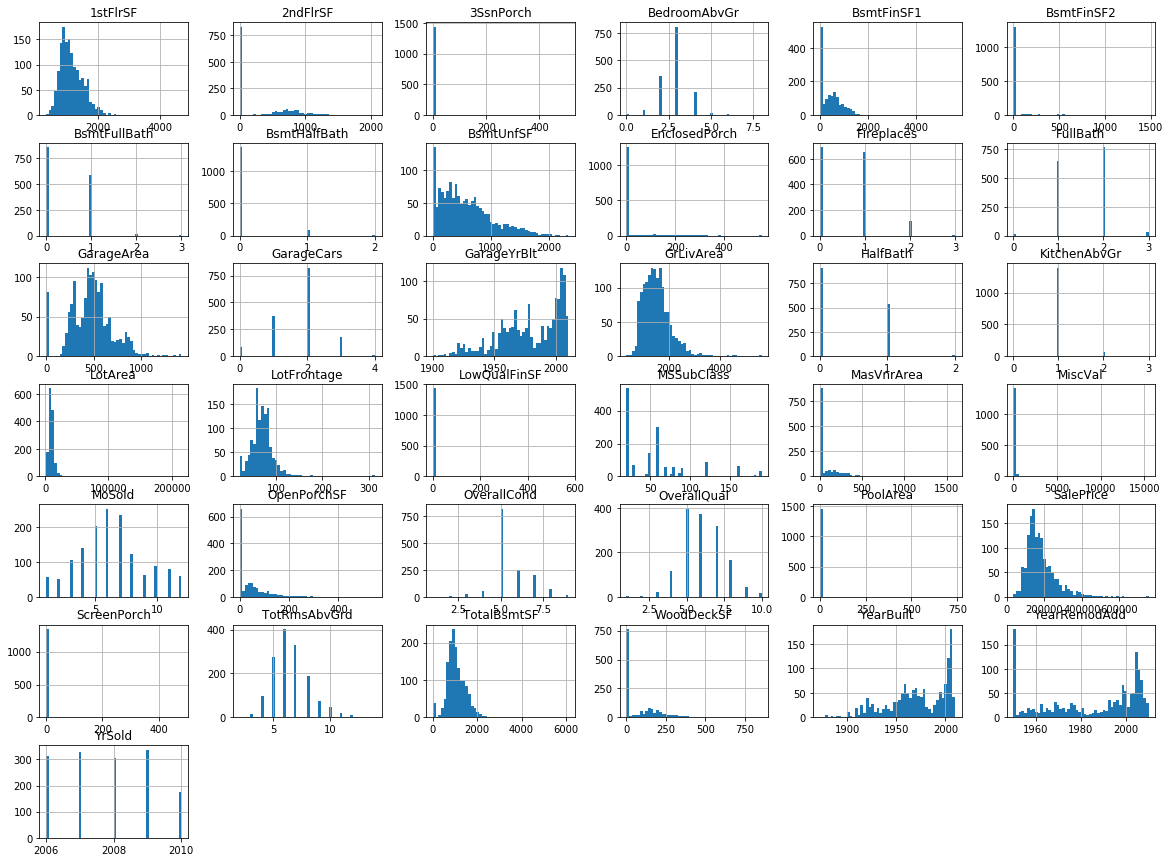

In [145]:
# Histogram of a variables
%matplotlib inline
import matplotlib.pyplot as plt
train.hist(bins=50,figsize=(20,15))
plt.show()

## 3. Prepare Data

In [146]:
# Additional feature, about all space
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']
train['TotalSF'].describe()

count     1460.000000
mean      2567.048630
std        821.714421
min        334.000000
25%       2009.500000
50%       2474.000000
75%       3004.000000
max      11752.000000
Name: TotalSF, dtype: float64

In [147]:
# searching for missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageType,81,0.055479
GarageQual,81,0.055479
GarageCond,81,0.055479


We choose delete all columns on percent is bigger than 0.15, after, we delete redundant information (Garage, Bsmt, MasVnr) and delete the row of Electrical missing value).

In [148]:
# deleting missing columns and missing rows
train = train.drop((missing_data[missing_data['Total'] > 1]).index,1)
train = train.drop(train.loc[train['Electrical'].isnull()].index)
train.isnull().sum().max() # checking for no missing data missing

0

In [149]:
# deleting missing columns and missing rows in test and set to 0 to all NaN/NULL
test = test.drop((missing_data[missing_data['Total'] > 1]).index,1)
test.fillna(0,inplace=True)
test.isnull().sum().max() # checking for no missing data missing

0

In [150]:
# convert categorial variables to discrete values, number of new cols = number of categories
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [151]:
# match cols in train and test (because is possible that some category does not exist in the train/test and is not discretized), after set 0 this discrete categories
missing_cols = set(train.drop(columns="SalePrice").columns) - set(test.columns)
for cols in missing_cols:
    test[cols] = 0
test = test[train.drop(columns="SalePrice").columns]
test.fillna(0,inplace=True)

In [152]:
# for a transformation of target value before the prediction with a normalized value (y-min)/(max-min)
min_saleprice=train['SalePrice'].min()
max_saleprice=train['SalePrice'].max()

In [153]:
# normalization
for var in train:
    train[var]=(train[var]-train[var].min())/(train[var].max()-train[var].min())
for var in test:
    test[var]=(test[var]-test[var].min())/(test[var].max()-test[var].min())

## 4. Splitting Data

In [154]:
# move SalePrice to y, we need reshape for a good matrix operations
X = train.drop(columns="SalePrice").values
X = np.column_stack((np.ones(X.shape[0]),X)) #Adding space for bias
y = train["SalePrice"].values
y = np.reshape(y,(y.shape[0],1))

In [155]:
# split data to train dataset and test dataset
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

# trying use sklearn to pre-processing the data
#from sklearn import preprocessing
#X_train = preprocessing.scale(X_train)
#X_test = preprocessing.scale(X_test)
#y_train = preprocessing.scale(y_train)
#y_test = preprocessing.scale(y_test)

In [156]:
# default split is 80% for training and 20% for testing
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

## 5. Linear Regression

In [157]:
# python solo implementation of Linear Regression with Batch Gradient Descent and RMSLE error (Kaggle scoreboard error)
alpha=0.00000001
theta=np.random.rand(1,X_train.shape[1])/X_train.shape[0]
max_epoch=5000000
for epoch in range(max_epoch):
    hx_train=np.matmul(theta,np.transpose(X_train))
    error=np.transpose(y_train)-hx_train
    dtheta=np.matmul(error,X_train)
    theta+=alpha*dtheta/X_train.shape[0]
    hx_test=np.matmul(theta,np.transpose(X_test))
    error=np.sqrt(np.mean((np.log(1+hx_test)- np.log(1+y_test))**2))
    if epoch%(max_epoch/1000)==0: #PRINTS ARE EVERY 1000 ITERATIONS
        print error   

0.57224237601716547
0.36205471456199607
0.23798173675199928
0.19468033442524748
0.18649361481269108
0.18330720821809151
0.18112111417805102
0.1809353322300038
0.18074986191221373
0.18056470276377196
0.18037985432459433
0.18019531613541923
0.18001108773780522
0.17982716867412846
0.17964355848758068
0.17946025672216648
0.17927726292270138
0.1790945766348091
0.17891219740491957
0.17873012478026634
0.1785483583088846
0.17836689753960844
0.17818574202206897
0.17800489130669184
0.1778243449446949
0.17764410248808613
0.17746416348966115
0.17728452750300114
0.17710519408247044
0.17692616278321438
0.1767474331611571
0.17656900477299925
0.17639087717621577
0.17621304992905348
0.17603552259052938
0.17585829472042783
0.17568136587929886
0.17550473562845556
0.1753284035299723
0.1751523691466822
0.17497663204217515
0.1748011917807956
0.17462604792764042
0.17445120004855666
0.17427664771013957
0.17410239047973017
0.17392842792541363
0.1737547596160165
0.17358138512110505
0.17340830401098306
0.1732355

0.1265961213687867
0.12650668298162235
0.12641741612841065
0.126328320551135
0.12623939599206616
0.12615064219376224
0.12606205889906763
0.12597364585111298
0.1258854027933142
0.1257973294693724
0.12570942562327297
0.1256216909992857
0.12553412534196337
0.12544672839614215
0.12535949990694037
0.12527243961975854
0.1251855472802786
0.1250988226344635
0.12501226542855684
0.12492587540908208
0.12483965232284223
0.1247535959169196
0.12466770593867481
0.12458198213574675
0.12449642425605202
0.12441103204778431
0.1243258052594139
0.12424074363968758
0.1241558469376279
0.12407111490253252
0.12398654728397424
0.12390214383180008
0.12381790429613118
0.12373382842736212
0.1236499159761606
0.12356616669346697
0.12348258033049377
0.1233991566387252
0.12331589536991697
0.12323279627609551
0.1231498591095578
0.12306708362287075
0.12298446956887105
0.12290201670066447
0.12281972477162544
0.12273759353539701
0.1226556227458898
0.12257381215728232
0.12249216152401979
0.1224106706008145
0.12232933914264

0.10151461765227215
0.10147710094200364
0.10143966992722087
0.10140232444693613
0.10136506434037437
0.10132788944697323
0.10129079960638272
0.1012537946584656
0.10121687444329694
0.1011800388011642
0.10114328757256721
0.101106620598218
0.10107003771904086
0.10103353877617235
0.10099712361096105
0.10096079206496765
0.10092454397996477
0.10088837919793708
0.10085229756108108
0.10081629891180513
0.10078038309272944
0.10074454994668579
0.10070879931671774
0.1006731310460804
0.10063754497824055
0.10060204095687633
0.10056661882587738
0.10053127842934459
0.10049601961159049
0.10046084221713857
0.10042574609072365
0.10039073107729171
0.10035579702199962
0.10032094377021554
0.10028617116751842
0.10025147905969817
0.10021686729275563
0.10018233571290218
0.10014788416656012
0.10011351250036236
0.10007922056115236
0.10004500819598414
0.10001087525212217
0.09997682157704134
0.09994284701842689
0.09990895142417429
0.09987513464238927
0.09984139652138778
0.0998077369096956
0.0997741556560488
0.09974

In [158]:
Z = test.values
Z = np.column_stack((np.ones(X.shape[0]),X)) #Adding space for bias
test_y_pred = np.matmul(theta,np.transpose(Z))
test_y_pred=np.transpose(test_y_pred)
test_y_pred=test_y_pred*(max_saleprice-min_saleprice)+min_saleprice
print test_y_pred
submission = pd.DataFrame(test_y_pred, index = np.arange(len(test_y_pred)))
submission.to_csv("submission.csv",index=False)